Deep Learning
=============

Assignment 2
------------

Previously in `1_notmnist.ipynb`, we created a pickle with formatted datasets for training, development and testing on the [notMNIST dataset](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html).

The goal of this assignment is to progressively train deeper and more accurate models using TensorFlow.

In [13]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import numpy as np
import tensorflow as tf
from six.moves import cPickle as pickle
from six.moves import range

import matplotlib.pyplot as plt
%matplotlib notebook

First reload the data we generated in `1_notmnist.ipynb`.

In [2]:
pickle_file = 'notMNIST.pickle'

with open(pickle_file, 'rb') as f:
  save = pickle.load(f)
  train_dataset = save['train_dataset']
  train_labels = save['train_labels']
  valid_dataset = save['valid_dataset']
  valid_labels = save['valid_labels']
  test_dataset = save['test_dataset']
  test_labels = save['test_labels']
  del save  # hint to help gc free up memory
  print('Training set', train_dataset.shape, train_labels.shape)
  print('Validation set', valid_dataset.shape, valid_labels.shape)
  print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 28, 28) (200000,)
Validation set (10000, 28, 28) (10000,)
Test set (10000, 28, 28) (10000,)


Reformat into a shape that's more adapted to the models we're going to train:
- data as a flat matrix,
- labels as float 1-hot encodings.

In [3]:
image_size = 28
num_labels = 10

def reformat(dataset, labels):
  dataset = dataset.reshape((-1, image_size * image_size)).astype(np.float32)
  # Map 0 to [1.0, 0.0, 0.0 ...], 1 to [0.0, 1.0, 0.0 ...]
  labels = (np.arange(num_labels) == labels[:,None]).astype(np.float32)
  return dataset, labels
train_dataset, train_labels = reformat(train_dataset, train_labels)
valid_dataset, valid_labels = reformat(valid_dataset, valid_labels)
test_dataset, test_labels = reformat(test_dataset, test_labels)
print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 784) (200000, 10)
Validation set (10000, 784) (10000, 10)
Test set (10000, 784) (10000, 10)


We're first going to train a multinomial logistic regression using simple gradient descent.

TensorFlow works like this:
* First you describe the computation that you want to see performed: what the inputs, the variables, and the operations look like. These get created as nodes over a computation graph. This description is all contained within the block below:

      with graph.as_default():
          ...

* Then you can run the operations on this graph as many times as you want by calling `session.run()`, providing it outputs to fetch from the graph that get returned. This runtime operation is all contained in the block below:

      with tf.Session(graph=graph) as session:
          ...

Let's load all the data into TensorFlow and build the computation graph corresponding to our training:

In [4]:
# With gradient descent training, even this much data is prohibitive.
# Subset the training data for faster turnaround.
train_subset = 10000

graph = tf.Graph()
with graph.as_default():

  # Input data.
  # Load the training, validation and test data into constants that are
  # attached to the graph.
  tf_train_dataset = tf.constant(train_dataset[:train_subset, :])
  tf_train_labels = tf.constant(train_labels[:train_subset])
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  
  # Variables.
  # These are the parameters that we are going to be training. The weight
  # matrix will be initialized using random values following a (truncated)
  # normal distribution. The biases get initialized to zero.
  weights = tf.Variable(
    tf.truncated_normal([image_size * image_size, num_labels]))
  biases = tf.Variable(tf.zeros([num_labels]))
  
  # Training computation.
  # We multiply the inputs with the weight matrix, and add biases. We compute
  # the softmax and cross-entropy (it's one operation in TensorFlow, because
  # it's very common, and it can be optimized). We take the average of this
  # cross-entropy across all training examples: that's our loss.
  logits = tf.matmul(tf_train_dataset, weights) + biases
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits))
  
  # Optimizer.
  # We are going to find the minimum of this loss using gradient descent.
  optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  # These are not part of training, but merely here so that we can report
  # accuracy figures as we train.
  train_prediction = tf.nn.softmax(logits)
  valid_prediction = tf.nn.softmax(
    tf.matmul(tf_valid_dataset, weights) + biases)
  test_prediction = tf.nn.softmax(tf.matmul(tf_test_dataset, weights) + biases)

Let's run this computation and iterate:

In [5]:
num_steps = 801

def accuracy(predictions, labels):
  return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

with tf.Session(graph=graph) as session:
  # This is a one-time operation which ensures the parameters get initialized as
  # we described in the graph: random weights for the matrix, zeros for the
  # biases. 
  tf.global_variables_initializer().run()
  print('Initialized')
  for step in range(num_steps):
    # Run the computations. We tell .run() that we want to run the optimizer,
    # and get the loss value and the training predictions returned as numpy
    # arrays.
    _, l, predictions = session.run([optimizer, loss, train_prediction])
    if (step % 100 == 0):
      print('Loss at step %d: %f' % (step, l))
      print('Training accuracy: %.1f%%' % accuracy(
        predictions, train_labels[:train_subset, :]))
      # Calling .eval() on valid_prediction is basically like calling run(), but
      # just to get that one numpy array. Note that it recomputes all its graph
      # dependencies.
      print('Validation accuracy: %.1f%%' % accuracy(
        valid_prediction.eval(), valid_labels))
  print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_labels))

Initialized
Loss at step 0: 19.688984
Training accuracy: 7.3%
Validation accuracy: 8.8%
Loss at step 100: 2.363645
Training accuracy: 71.7%
Validation accuracy: 70.6%
Loss at step 200: 1.899925
Training accuracy: 74.9%
Validation accuracy: 73.1%
Loss at step 300: 1.648618
Training accuracy: 76.2%
Validation accuracy: 73.9%
Loss at step 400: 1.473920
Training accuracy: 77.2%
Validation accuracy: 74.5%
Loss at step 500: 1.342163
Training accuracy: 77.8%
Validation accuracy: 74.7%
Loss at step 600: 1.238849
Training accuracy: 78.4%
Validation accuracy: 75.0%
Loss at step 700: 1.155432
Training accuracy: 79.0%
Validation accuracy: 75.1%
Loss at step 800: 1.086577
Training accuracy: 79.5%
Validation accuracy: 75.1%
Test accuracy: 82.7%


Let's now switch to stochastic gradient descent training instead, which is much faster.

The graph will be similar, except that instead of holding all the training data into a constant node, we create a `Placeholder` node which will be fed actual data at every call of `session.run()`.

In [6]:
batch_size = 128

graph = tf.Graph()
with graph.as_default():

  # Input data. For the training data, we use a placeholder that will be fed
  # at run time with a training minibatch.
  tf_train_dataset = tf.placeholder(tf.float32,
                                    shape=(batch_size, image_size * image_size))
  tf_train_labels  = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset  = tf.constant(test_dataset)
  
  # Variables.
  weights = tf.Variable(
    tf.truncated_normal([image_size * image_size, num_labels]))
  biases = tf.Variable(tf.zeros([num_labels]))
  
  # Training computation.
  logits = tf.matmul(tf_train_dataset, weights) + biases
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits))
  
  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  valid_prediction = tf.nn.softmax(
    tf.matmul(tf_valid_dataset, weights) + biases)
  test_prediction = tf.nn.softmax(tf.matmul(tf_test_dataset, weights) + biases)

Let's run it:

In [7]:
num_steps = 3001

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print("Initialized")
  for step in range(num_steps):
    # Pick an offset within the training data, which has been randomized.
    # Note: we could use better randomization across epochs.
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    # Generate a minibatch.
    batch_data = train_dataset[offset:(offset + batch_size), :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    # Prepare a dictionary telling the session where to feed the minibatch.
    # The key of the dictionary is the placeholder node of the graph to be fed,
    # and the value is the numpy array to feed to it.
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 500 == 0):
      print("Minibatch loss at step %d: %f" % (step, l))
      print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
      print("Validation accuracy: %.1f%%" % accuracy(
        valid_prediction.eval(), valid_labels))
  print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 17.953503
Minibatch accuracy: 9.4%
Validation accuracy: 8.1%
Minibatch loss at step 500: 1.782739
Minibatch accuracy: 79.7%
Validation accuracy: 76.1%
Minibatch loss at step 1000: 1.329088
Minibatch accuracy: 78.9%
Validation accuracy: 76.5%
Minibatch loss at step 1500: 1.007178
Minibatch accuracy: 79.7%
Validation accuracy: 77.1%
Minibatch loss at step 2000: 0.735577
Minibatch accuracy: 78.9%
Validation accuracy: 77.1%
Minibatch loss at step 2500: 0.854538
Minibatch accuracy: 73.4%
Validation accuracy: 77.6%
Minibatch loss at step 3000: 0.844200
Minibatch accuracy: 85.2%
Validation accuracy: 78.3%
Test accuracy: 85.7%


---
Problem
-------

Turn the logistic regression example with SGD into a 1-hidden layer neural network with rectified linear units [nn.relu()](https://www.tensorflow.org/versions/r0.7/api_docs/python/nn.html#relu) and 1024 hidden nodes. This model should improve your validation / test accuracy.

---

## Define the model

In [9]:
batch_size = 128

graph = tf.Graph()
with graph.as_default():

  # Input data. For the training data, we use a placeholder that will be fed
  # at run time with a training minibatch.
  tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_size * image_size))
  tf_train_labels  = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset  = tf.constant(test_dataset)
    
  regul_param = tf.placeholder(tf.float32, shape=() )
  
  # Variables.
  numhidden = 64
  weights0 = tf.Variable(tf.truncated_normal([image_size * image_size, numhidden]))
  biases0 = tf.Variable(tf.zeros([numhidden]))

  weights1 = tf.Variable(tf.truncated_normal([numhidden, num_labels]))
  biases1 = tf.Variable(tf.zeros([num_labels]))
  
  # Compute hidden layer activations computation.
  logits = tf.matmul(tf_train_dataset, weights0) + biases0
  activations0 = tf.nn.relu(logits)

  #Compute logits
  logits = tf.matmul(activations0, weights1) + biases1
  
  #loss function without regularization
  loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits))
    
  #loss funtion with regularization
  loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=tf_train_labels)) +\
            regul_param*tf.nn.l2_loss(weights0) +\
            regul_param*tf.nn.l2_loss(weights1) +\
            regul_param*tf.nn.l2_loss(biases0) +\
            regul_param*tf.nn.l2_loss(biases1)
  
  
  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
    
  valid_prediction = tf.matmul(tf_valid_dataset, weights0) + biases0
  valid_prediction = tf.nn.relu(valid_prediction)
  valid_prediction = tf.matmul(valid_prediction, weights1) + biases1
  valid_prediction = tf.nn.softmax(valid_prediction)
    
  test_prediction = tf.matmul(tf_test_dataset, weights0) + biases0
  test_prediction = tf.nn.relu(test_prediction)
  test_prediction = tf.matmul(test_prediction, weights1) + biases1
  test_prediction = tf.nn.softmax(test_prediction)

  #test_prediction = tf.nn.softmax(tf.matmul(tf_test_dataset, weights) + biases)

In [35]:
num_steps = 3001

numsteps=[int(i) for i in np.logspace(1,4,10)]
test_accs = []
valid_accs = []



with tf.Session(graph=graph) as session:

  for maxstep in numsteps:
    tf.global_variables_initializer().run()
    print("Initialized")
    print("Running up to:",maxstep,"steps")
    for step in range(maxstep):
        # Pick an offset within the training data, which has been randomized.
        # Note: we could use better randomization across epochs.
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        # Generate a minibatch.
        batch_data = train_dataset[offset:(offset + batch_size), :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        # Prepare a dictionary telling the session where to feed the minibatch.
        # The key of the dictionary is the placeholder node of the graph to be fed,
        # and the value is the numpy array to feed to it.
        feed_dict = {tf_train_dataset : batch_data,
                     tf_train_labels : batch_labels,
                     regul_param : 0.0}
        _, l, predictions = session.run(
          [optimizer, loss, train_prediction], feed_dict=feed_dict)
        if (step % 500 == 0 and False):
          print("Minibatch loss at step %d: %f" % (step, l))
          print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
          print("Validation accuracy: %.1f%%" % accuracy(
            valid_prediction.eval(), valid_labels))
    print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))
    test_accs.append(accuracy(test_prediction.eval(), test_labels))
    valid_accs.append(accuracy(valid_prediction.eval(), valid_labels))
  

Initialized
Running up to: 10 steps
Test accuracy: 63.4%
Initialized
Running up to: 21 steps
Test accuracy: 73.6%
Initialized
Running up to: 46 steps
Test accuracy: 72.2%
Initialized
Running up to: 100 steps
Test accuracy: 76.4%
Initialized
Running up to: 215 steps
Test accuracy: 75.6%
Initialized
Running up to: 464 steps
Test accuracy: 80.2%
Initialized
Running up to: 1000 steps
Test accuracy: 83.5%
Initialized
Running up to: 2154 steps
Test accuracy: 85.8%
Initialized
Running up to: 4641 steps
Test accuracy: 88.4%
Initialized
Running up to: 10000 steps
Test accuracy: 89.3%


<IPython.core.display.Javascript object>


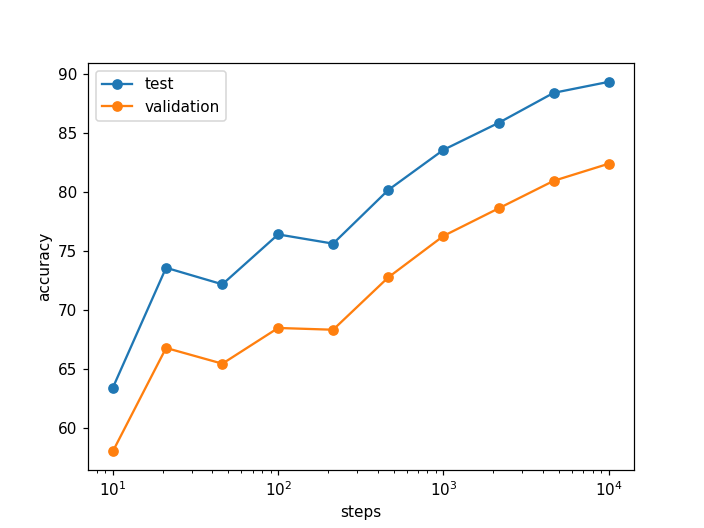

In [36]:
plt.figure()
plt.semilogx(numsteps,test_accs,'-o',label="test")
plt.semilogx(numsteps,valid_accs,'-o',label="validation")
plt.xlabel("steps"); plt.ylabel("accuracy")
plt.legend()

## Print accuracies for different regularization parameters

In [38]:
num_steps = 3001

batch_accs2 = []; batch_l = []; 
valid_accs2 = []; valid_l = []; 
test_accs2  = []; test_l = []; 
ls = []
regparams = np.logspace(-4,-1,12)

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print("Initialized")
    
  for alpha in regparams:
      print("alpha:",alpha)
      for step in range(num_steps):
        # Pick an offset within the training data, which has been randomized.
        # Note: we could use better randomization across epochs.
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        # Generate a minibatch.
        batch_data = train_dataset[offset:(offset + batch_size), :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        # Prepare a dictionary telling the session where to feed the minibatch.
        # The key of the dictionary is the placeholder node of the graph to be fed,
        # and the value is the numpy array to feed to it.
        feed_dict = {tf_train_dataset : batch_data,
                     tf_train_labels : batch_labels,
                     regul_param: alpha} #l2-regularization parameter
        xx, l, predictions = session.run(
          [optimizer, loss, train_prediction], feed_dict=feed_dict)
      batch_accs2.append(accuracy(predictions, batch_labels))
      valid_accs2.append(accuracy(valid_prediction.eval(), valid_labels))
      test_accs2.append(accuracy(test_prediction.eval(), test_labels))
      ls.append(l)
      numsteps.append(step)
      print("  Minibatch loss at step %d: %f" % (step, l))
      print("  Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
      print("  Validation accuracy: %.1f%%" % accuracy(valid_prediction.eval(), valid_labels))
      print("  Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Initialized
alpha: 0.0001
  Minibatch loss at step 3000: 2.024007
  Minibatch accuracy: 82.0%
  Validation accuracy: 79.8%
  Test accuracy: 87.0%
alpha: 0.000187381742286
  Minibatch loss at step 3000: 1.940639
  Minibatch accuracy: 87.5%
  Validation accuracy: 83.1%
  Test accuracy: 89.9%
alpha: 0.000351119173422
  Minibatch loss at step 3000: 1.338601
  Minibatch accuracy: 90.6%
  Validation accuracy: 84.7%
  Test accuracy: 91.5%
alpha: 0.000657933224658
  Minibatch loss at step 3000: 0.673545
  Minibatch accuracy: 89.1%
  Validation accuracy: 86.4%
  Test accuracy: 92.4%
alpha: 0.00123284673944
  Minibatch loss at step 3000: 0.494588
  Minibatch accuracy: 86.7%
  Validation accuracy: 86.2%
  Test accuracy: 92.3%
alpha: 0.00231012970008
  Minibatch loss at step 3000: 0.518429
  Minibatch accuracy: 86.7%
  Validation accuracy: 85.9%
  Test accuracy: 92.0%
alpha: 0.00432876128108
  Minibatch loss at step 3000: 0.554724
  Minibatch accuracy: 86.7%
  Validation accuracy: 85.0%
  Test acc

<IPython.core.display.Javascript object>


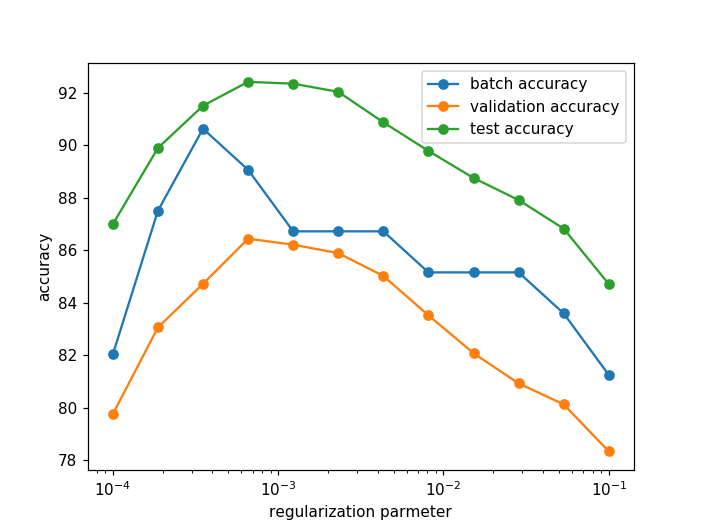

In [39]:
plt.figure()
plt.semilogx(regparams,batch_accs2,'-o',label='batch accuracy')
plt.semilogx(regparams,valid_accs2,'-o',label='validation accuracy')
plt.semilogx(regparams,test_accs2,'-o' ,label='test accuracy')
plt.xlabel('regularization parmeter')
plt.ylabel('accuracy')
plt.legend()